<a href="https://colab.research.google.com/github/srivatsakr21/siemens-sustainability-challenge/blob/main/Sentiment_analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import csv
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud

# Downloads
nlp = spacy.load('en')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Preprocessing
import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# **Read the twitter data**
Read the twitter data extracted using phase 1.

In [79]:
data = pd.read_csv('Microsoft_tweets.csv')

In [80]:
data.head()

,content
0,RT @KlyngeC: We're hiring for the @MicrosoftEU...
1,RT @carsten_growth: One of the reasons talking...
2,RT @Azure: Announcing the general availability...
3,Which Fortune 500 company offers the best sust...
4,RT @arc_advisory: Join Gold Sponsor #Microsoft...


# **Hashtag extractor**
In twitter people use hashtags and these hashtags serve as a purpose to understand what the person is trying to tell. When we analysed twitter data of multiple companies we found that more tangible actions like celebrating hydrogen day or fuel cell day gets highlighted. Other common topics like decarbonization and carbonneutral also gets tweeted a lot.
But for some companies that are not popular as others people do not react regarding their sustainability actions. For example we could not find any public reactions on the sustainability actions taken by Walt Disney.


In [4]:
def hashtag_extract(tweet):
    
    """
    This function takes in a tweet and extracts the top 15 hashtag(s) using regular expressions
    These hashtags are stored in a seperate dataframe 
    along with a count of how frequenty they occur
    
    Input:
    tweet: original tweets
           datatype: 'str'
           
    Output:
    hashtag_df: dataframe containing the top hashtags in the tweets
              datatype: dataframe         
    """
    
    hashtags = []
    
    for i in tweet:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

In [81]:
hashtag_df = hashtag_extract(data['content'])

In [82]:
hashtag_df

,hashtag,count
2,Microsoft,53
26,Azure,37
11,sustainability,32
20,cloud,21
7,azure,16
30,Cloud,9
27,CloudStrategy,7
48,microsoft,7
21,EdgeMethods,6
40,Sustainability,5


In [83]:
def TweetCleaner(tweet):
    
    """
    This function uses regular expressions to remove url's, mentions, hashtags, 
    punctuation, numbers and any extra white space from tweets after converting 
    everything to lowercase letters.

    Input:
    tweet: original tweet
           datatype: 'str'

    Output:
    tweet: modified tweet
           datatype: 'str'
    """
    # Convert everything to lowercase
    tweet = tweet.lower() 
    
    # Remove mentions   
    tweet = re.sub('@[\w]*','',tweet)  
    
    # Remove url's
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)    
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)  
    
    # Remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    # Remove that funny diamond
    tweet = re.sub(r"U+FFFD ", ' ', tweet)
    
    # Remove extra whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove space in front of tweet
    tweet = tweet.lstrip(' ')                        
    
    return tweet

In [84]:
df = data.copy()

In [85]:
data['content'] = data['content'].apply(TweetCleaner)

In [86]:
data

,content
0,rt we re hiring for the team in the key areas ...
1,rt one of the reasons talking about cloud solu...
2,rt announcing the general availability of the ...
3,which fortune company offers the best sustaina...
4,rt join gold sponsor at the th annual - accele...
...,...
574,the ocean plastic mouse is a small step forwar...
575,it s awesome to see exploring sustainable mate...
576,econaur is back with the second edition of eco...
577,hololens augmented reality is helping a conser...


In [11]:
def lemma(df):
    
    """
    This function modifies the original train dataframe.
    A new column for the length of each tweet is added.
    The tweets are then tokenized and each word is assigned a part of speech tag 
    before being lemmatized
    
    Input:
    df: original dataframe
        datatype: dataframe 
        
    Output:
    df: modified dataframe
        datatype: dataframe
    """
    
    df['length'] = df['content'].str.len()
    df['tokenized'] = df['content'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

    def get_wordnet_pos(tag):

        if tag.startswith('J'):
            return wordnet.ADJ

        elif tag.startswith('V'):
            return wordnet.VERB

        elif tag.startswith('N'):
            return wordnet.NOUN

        elif tag.startswith('R'):
            return wordnet.ADV
    
        else:
            return wordnet.NOUN
        
    wnl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

In [87]:
data = lemma(data)

In [88]:
data.head()

,content,length,tokenized,pos_tags,lemmatized
0,rt we re hiring for the team in the key areas ...,114,"[rt, we, re, hiring, for, the, team, in, the, ...","[(rt, n), (we, n), (re, v), (hiring, v), (for,...",rt we re hire for the team in the key area of ...
1,rt one of the reasons talking about cloud solu...,92,"[rt, one, of, the, reasons, talking, about, cl...","[(rt, v), (one, n), (of, n), (the, n), (reason...",rt one of the reason talk about cloud solution...
2,rt announcing the general availability of the ...,126,"[rt, announcing, the, general, availability, o...","[(rt, n), (announcing, v), (the, n), (general,...",rt announce the general availability of the mi...
3,which fortune company offers the best sustaina...,109,"[which, fortune, company, offers, the, best, s...","[(which, n), (fortune, v), (company, n), (offe...",which fortune company offer the best sustainab...
4,rt join gold sponsor at the th annual - accele...,58,"[rt, join, gold, sponsor, at, the, th, annual,...","[(rt, n), (join, n), (gold, n), (sponsor, n), ...",rt join gold sponsor at the th annual - accele...


In [64]:
def entity_extractor(tweet):
    
    """
    This function extracts the top 10 people, organizations and geopolitical entities 
    in a collection of tweets. 
    The information is then saved in a new dataframe

    Input:
    tweet: lemmatized tweets
           datatype: 'str'

    Output:
    df: dataframe containing the top 10 people, organizations and gpe's in a collection of tweets
        datatype: dataframe ('str')
    """
    
    def get_people(tweet):  
        words = nlp(tweet)
        people = [w.text for w in words.ents if w.label_== 'PERSON']
        return people
    
    def get_org(tweet):
        words = nlp(tweet)
        org = [w.text for w in words.ents if w.label_== 'ORG']
        return org
    
    def get_gpe(tweet):
        words = nlp(tweet)
        gpe = [w.text for w in words.ents if w.label_== 'GPE']
        return gpe
    
    # Extract the top 10 people
    people = tweet.apply(lambda x: get_people(x)) 
    people = [x for sub in people for x in sub]
    people_counter = Counter(people)
    people_count = people_counter.most_common(10)
    people, people_count = map(list, zip(*people_count))
    
    # Extract the top 10 organizations
    org = tweet.apply(lambda x: get_org(x)) 
    org = [x for sub in org for x in sub]
    org_counter = Counter(org)
    org_count = org_counter.most_common(10)
    org, org_count = map(list, zip(*org_count))
    
    # Extract the top 10 geopolitical entities
    gpe = tweet.apply(lambda x: get_gpe(x)) 
    gpe = [x for sub in gpe for x in sub]
    gpe_counter = Counter(gpe)
    gpe_count = gpe_counter.most_common(10)
    gpe, gpe_count = map(list, zip(*gpe_count))
    
    # Create a dataframe to store the information
    df = pd.DataFrame({'people' : people})
    df['geopolitics'] = gpe
    df['organizations'] = org
    
    return df

In [48]:
df_entity

,people,geopolitics,organizations
0,scott morrison,india,australia trust
1,barnaby joyce,australia,hon ble union
2,joe,morocco,congress
3,rt biden s,west virginia,australia s rich iron ore
4,julia gillard,el salvador,hon
5,tony abbott destroye,new mexico,miner union
6,forrest,germany,govt
7,arif alvi,scotland,eu
8,don,china,scotland s electricity
9,k singh,uk,⛽


In [17]:
!pip install yake

     |████████████████████████████████| 60 kB 6.7 MB/s 
     |████████████████████████████████| 134 kB 75.1 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.8.8-cp37-cp37m-linux_x86_64.whl size=73230 sha256=ceab5951617eef4530db15c873f8b6b2dded3d3272e1d326fd5d1dfbb3979321
  Stored in directory: /root/.cache/pip/wheels/82/aa/f4/716387e1f167cbbf911488aa056138152f4d8699c9c9b43ea8
  Created wheel for segtok: filename=segtok-1.5.10-py3-none-any.whl size=25030 sha256=408adf8e1491be88467d1ef22bf1f70b548062867f4e066645febf78ebf8dfab
  Stored in directory: /root/.cache/pip/wheels/67/b7/d0/a121106e61339eee5ed083bc230b1c8dc422c49a5a28c2addd
Successfully built jellyfish segtok


# **Keyword extraction**
Since the tweets we extract are not labelled, here we will have to work with unsupervised keyword extraction. For this purpose we use yake. For microsoft we found that an announcement regarding the emissions impact dashboard was a huge hit and a lot of people were talking about it. Along with this cloud sustainability was also a hot topic.

In [49]:
import yake

In [90]:
text = ' '.join(data['content'].values.tolist())

In [91]:
text

'rt we re hiring for the team in the key areas of sustainability economic policy and responsible tech come help us… rt one of the reasons talking about cloud solution is to fulfill on goals check out this fo… rt announcing the general availability of the microsoft emissions impact dashboard now customers can track report analyze and… which fortune company offers the best sustainability initiatives to address diversity ethics environment an…  rt join gold sponsor at the th annual - accelerating and … join gold sponsor at the th annual - accelerating and…  rt tracking and replacing carbon emissions with the cloud ☁️ this urgent innovation for global organizations helps protect ou… cgna preferred vendor is schneider electric recognized as microsoft sustainability changemaker partner of the…  rt tracking and replacing carbon emissions with the cloud ☁️ this urgent innovation for global organizations helps protect ou… rt tracking and replacing carbon emissions with the cloud ☁️ this urgent 

In [92]:
language = "en"
max_ngram_size = 3
deduplication_thresold = 0.9
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 15

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text)

for kw in keywords:
    print(kw)

('emissions impact dashboard', 9.55115079573563e-09)
('microsoft emissions impact', 1.0914727913362428e-08)
('empowering cloud sustainability', 1.8060325652237156e-08)
('impact dashboard empowering', 5.47771622448044e-08)
('dashboard empowering cloud', 6.12754560699345e-08)
('ocean plastic mouse', 3.124817486015566e-07)
('microsoft cloud customers', 3.367368559639981e-07)
('small step forward', 6.338136167330642e-07)
('emissions impact', 6.52607719953468e-07)
('replacing carbon emissions', 7.802733206900963e-07)
('impact dashboard', 8.566645807178455e-07)
('microsoft emissions', 9.033744476806539e-07)
('cloud sustainability', 1.0542969284644983e-06)
('impact dashboard cloud', 1.1244430428130509e-06)
('impact dashboard officially', 1.530932504653274e-06)


# **Sentiment analysis**
As we do not have labelled data for sentiment analysis we used pretrained SentimentIntensityAnalyser. We found that for microsoft, majority of the tweets have been positive or neutral.

In [27]:
import nltk
nltk.download('vader_lexicon')       
from nltk.sentiment.vader import SentimentIntensityAnalyzer 


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [32]:
def extract_sentiment(text):
  si = SentimentIntensityAnalyzer()
  sentiment_dict = si.polarity_scores(text)
  if sentiment_dict['compound'] >= 0.05 :
        return "Positive"
 
  elif sentiment_dict['compound'] <= - 0.05 :
      return "Negative"
 
  else:
      return "Neutral"

In [93]:
data['sentiment_scores'] = data['content'].apply(lambda x: extract_sentiment(x))

In [94]:
data.groupby(by='sentiment_scores').count()

,content,length,tokenized,pos_tags,lemmatized
sentiment_scores,,,,,
Negative,12,12,12,12,12
Neutral,340,340,340,340,340
Positive,227,227,227,227,227


In [74]:
def create_wordcloud(sentences):
  all_text=[]
  for i, text in enumerate(sentences):
    all_text.append(text)
    text = ' '.join(text for text in all_text)

  # Create and generate a word cloud image:
  wordcloud = WordCloud(max_font_size=50,stopwords = STOPWORDS, max_words=200, background_color="white").generate(text)

  # Display the generated image:
  plt.figure( figsize=(20,20), facecolor='k' )
  plt.tight_layout(pad=0)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()  


In [76]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Finally, we create a word cloud to summarise the most talked about topics about microsoft.

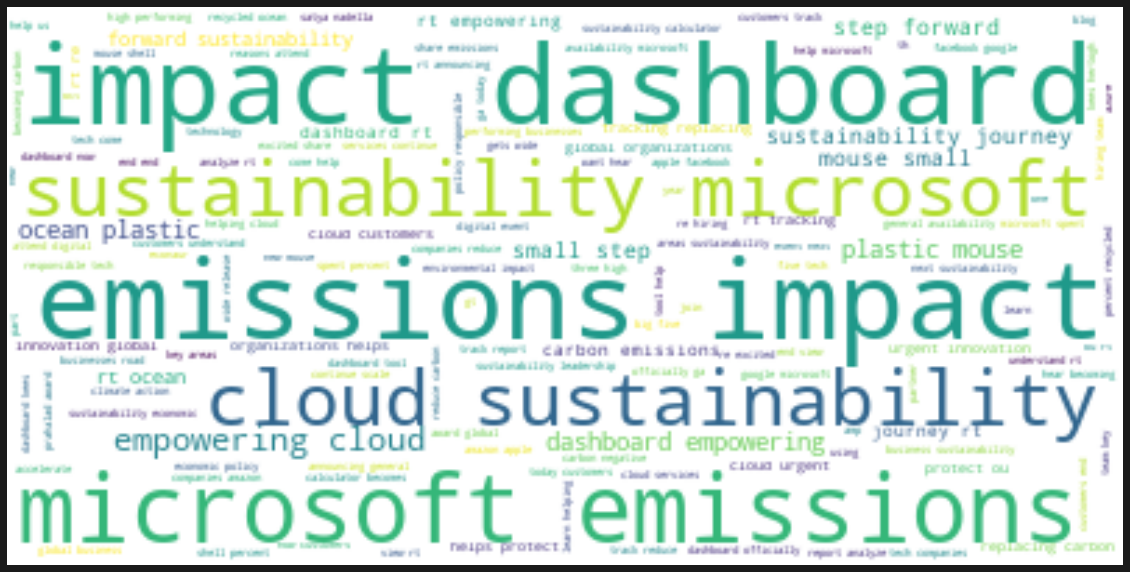

In [95]:
create_wordcloud(data['content'])